In [106]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statsbombpy import sb
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

pd.set_option('display.max_columns', 100)

In [4]:
sb.competitions().query("competition_name == 'La Liga'").sort_values("season_name", ascending=False).head(3)

/Users/ali/mambaforge/envs/ali/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
20,11,90,Spain,La Liga,male,False,False,2020/2021,2022-02-11T14:56:09.076,2022-08-16T21:50:36.812060,2022-08-16T21:50:36.812060,2022-02-11T14:56:09.076
21,11,42,Spain,La Liga,male,False,False,2019/2020,2022-07-15T23:27:24.260122,2021-06-13T16:17:31.694,None,2022-07-15T23:27:24.260122
22,11,4,Spain,La Liga,male,False,False,2018/2019,2022-08-30T23:25:57.118855,2021-07-09T14:53:22.103024,None,2022-08-30T23:25:57.118855


In [5]:
LALIGA_ID = 11
SEASON_2021_ID = 90 

In [6]:
all_matches = sb.matches(competition_id=LALIGA_ID, season_id=SEASON_2021_ID)
match_passes = pd.concat(
               [sb.events(match_id=match_id, split=True, flatten_attrs=False)["passes"]
               .assign(match_week = match_week) 
               .assign(home_team = home_team)
               .assign(away_team = away_team)
               for match_id, match_week, home_team, away_team 
               in zip(
                    all_matches["match_id"], all_matches["match_week"],
                    all_matches["home_team"], all_matches["away_team"]
                     )
                ]
               )

/Users/ali/mambaforge/envs/ali/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)
/Users/ali/mambaforge/envs/ali/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)
/Users/ali/mambaforge/envs/ali/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)
/Users/ali/mambaforge/envs/ali/lib/python3.8/site-packages/statsbombpy/api_client.py:20: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn("credentials were not supplied. open data access only", NoAuthWarning)
/Users/ali/mambaforge/en

In [7]:
print(f"Dataset with {len(match_passes):,} passes")
print(list(match_passes.columns))

Dataset with 40,337 passes
['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type', 'possession', 'possession_team', 'play_pattern', 'team', 'player', 'position', 'location', 'duration', 'related_events', 'pass', 'match_id', 'possession_team_id', 'player_id', 'under_pressure', 'counterpress', 'off_camera', 'match_week', 'home_team', 'away_team', 'out']


In [8]:
def extract_pass_features(df):
    
    df["outcome"] = df["pass"].apply(lambda x : x.get("outcome", {}).get("name"))
    df["recipient_id"] = df["pass"].apply(lambda x : x.get("recipient", {}).get("id"))
    df["length"] = df["pass"].apply(lambda x : x.get("length"))
    df["angle"] = df["pass"].apply(lambda x : x.get("angle"))
    df["height"] = df["pass"].apply(lambda x : x.get("height", {}).get("name"))
    df["body_part"] = df["pass"].apply(lambda x : x.get("body_part", {}).get("name"))
    df["end_location"] = df["pass"].apply(lambda x : x.get("end_location"))
    df["home"] = df["possession_team"] == df["home_team"]
    df["opponent"] = df.apply(lambda x : x["home_team"] if x["home_team"] != x["possession_team"] else x["away_team"], axis=1)
    df["n_related_events"] = df.related_events.apply(lambda x : len(x) if type(x) == list else None).fillna(0)

    return df

def manage_nas(df):
    for column in ["under_pressure", "counterpress", "off_camera"]:
        df[column] = df[column].fillna(False)
    df["outcome"] = df["outcome"].fillna("Completed")
    return df

In [9]:
match_passes = extract_pass_features(match_passes)
match_passes = manage_nas(match_passes)

# Number of passes attempted by Barcelona vs opponents

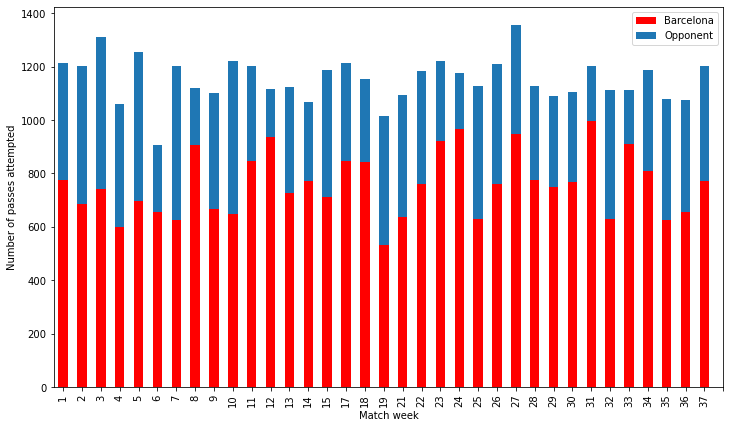

In [10]:
match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), color = "red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").match_week.value_counts().sort_index().plot.bar(figsize=(12,7), bottom = match_passes.query("possession_team == 'Barcelona'").match_week.value_counts().sort_index(), label="Opponent")
plt.xlabel("Match week")
plt.ylabel("Number of passes attempted")
plt.xticks(range(0,36))
plt.legend();

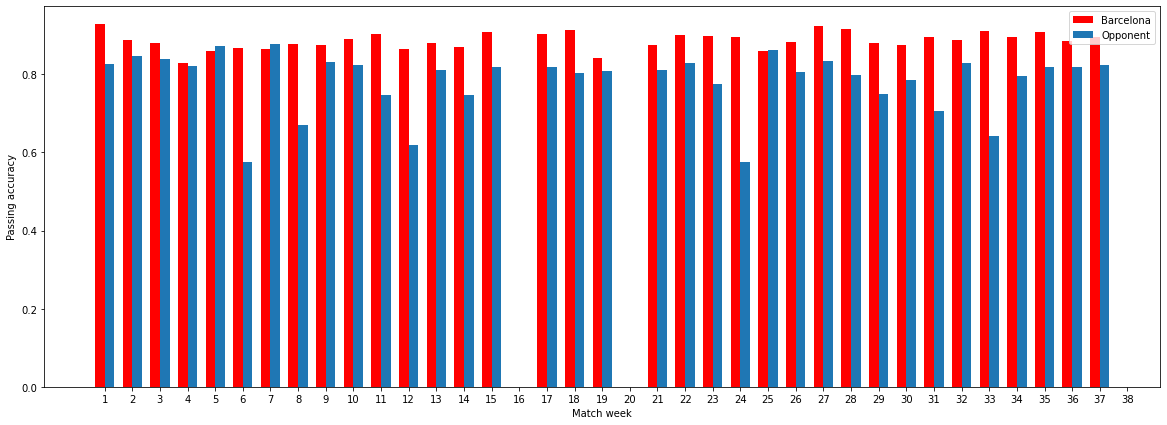

In [11]:
plt.figure(figsize=(20,7))
barcelona = match_passes.query("possession_team == 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
plt.bar(barcelona.index, barcelona.values, width=0.35, color="red", label ="Barcelona")

opponents = match_passes.query("possession_team != 'Barcelona'").groupby("match_week").outcome.value_counts(normalize=True).loc[:,"Completed", :]
opponents.index = (opponents.index + 0.35).astype(float)
plt.bar(opponents.index, opponents.values, width=0.35, label="Opponent")
plt.xticks([x+0.35/2 for x in range(1, 39)], range(1, 39));
plt.xlabel("Match week")
plt.ylabel("Passing accuracy")
plt.legend(loc="upper right");

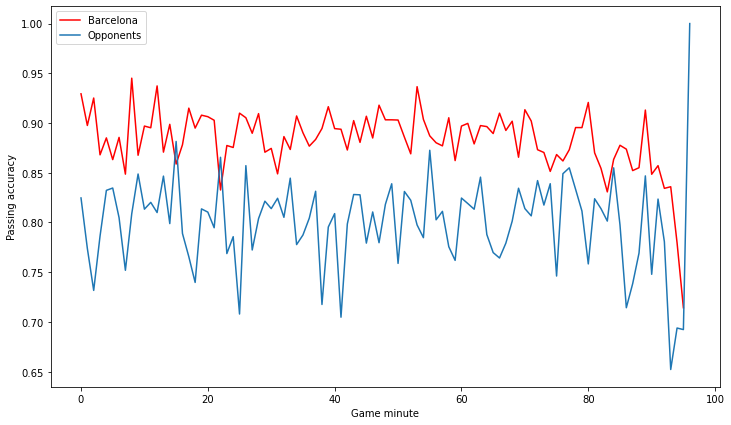

In [12]:
plt.figure(figsize=(12,7))
match_passes.query("possession_team == 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(color="red", label="Barcelona")
match_passes.query("possession_team != 'Barcelona'").groupby("minute")["outcome"].value_counts(normalize=True).loc[:,"Completed"].plot(label="Opponents")
plt.xlabel("Game minute")
plt.ylabel("Passing accuracy")
plt.legend();

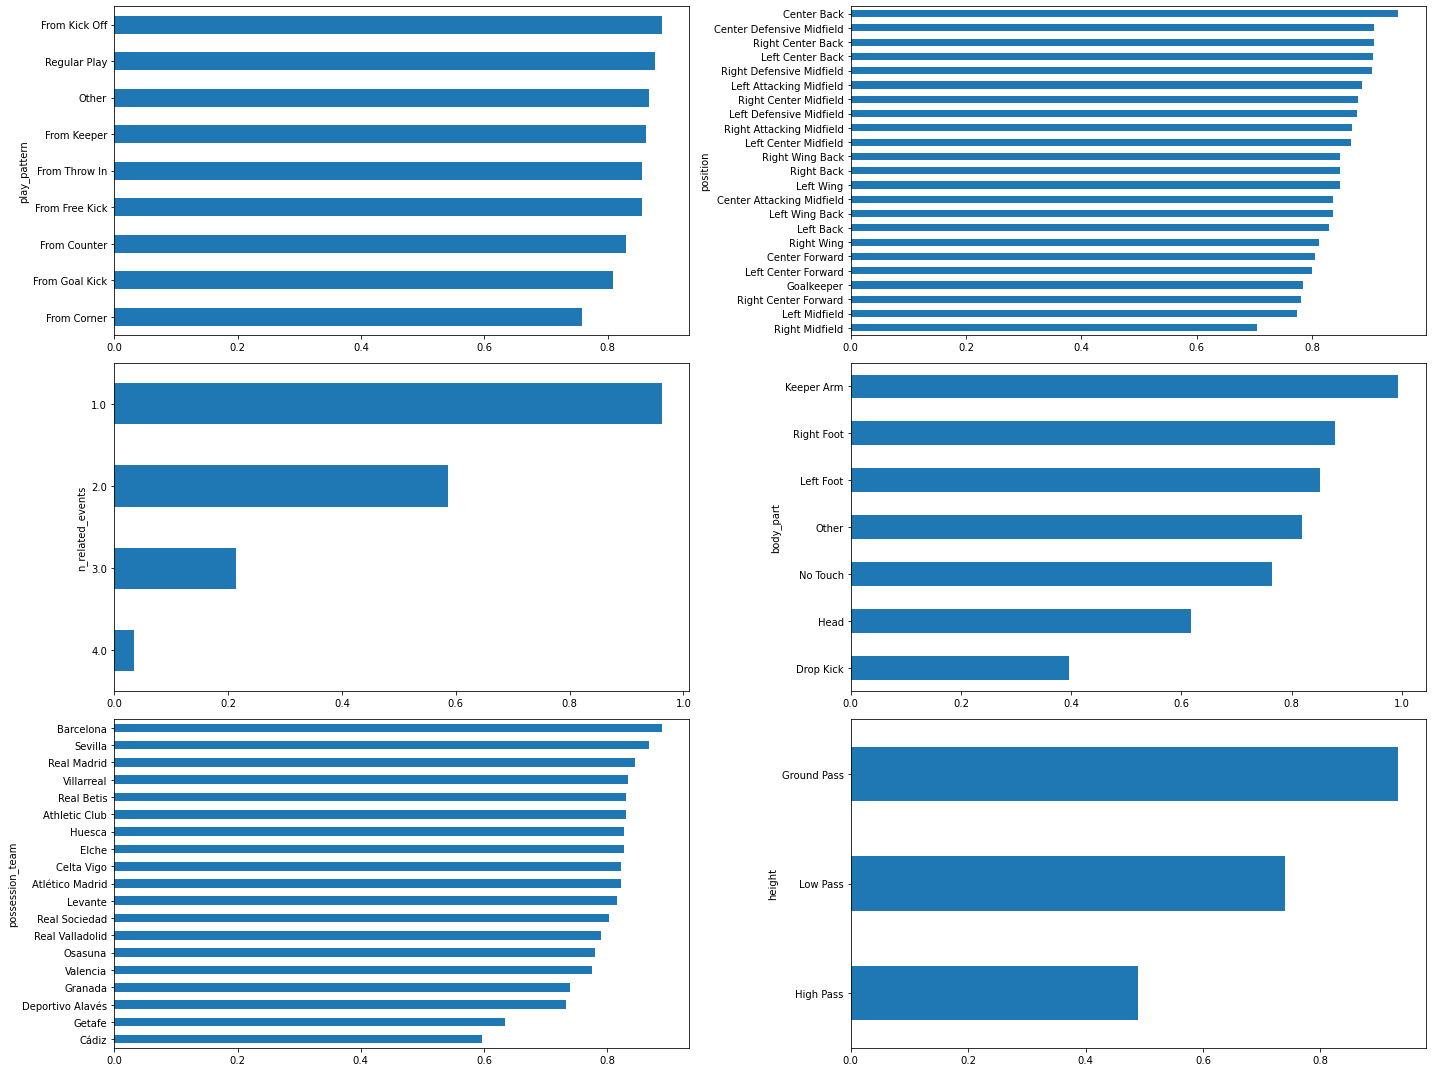

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
for i, column in enumerate(["play_pattern", "position", "n_related_events", "body_part", "possession_team", "height"], 1):
    ax = plt.subplot(3, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.barh(ax=ax)

fig.tight_layout()

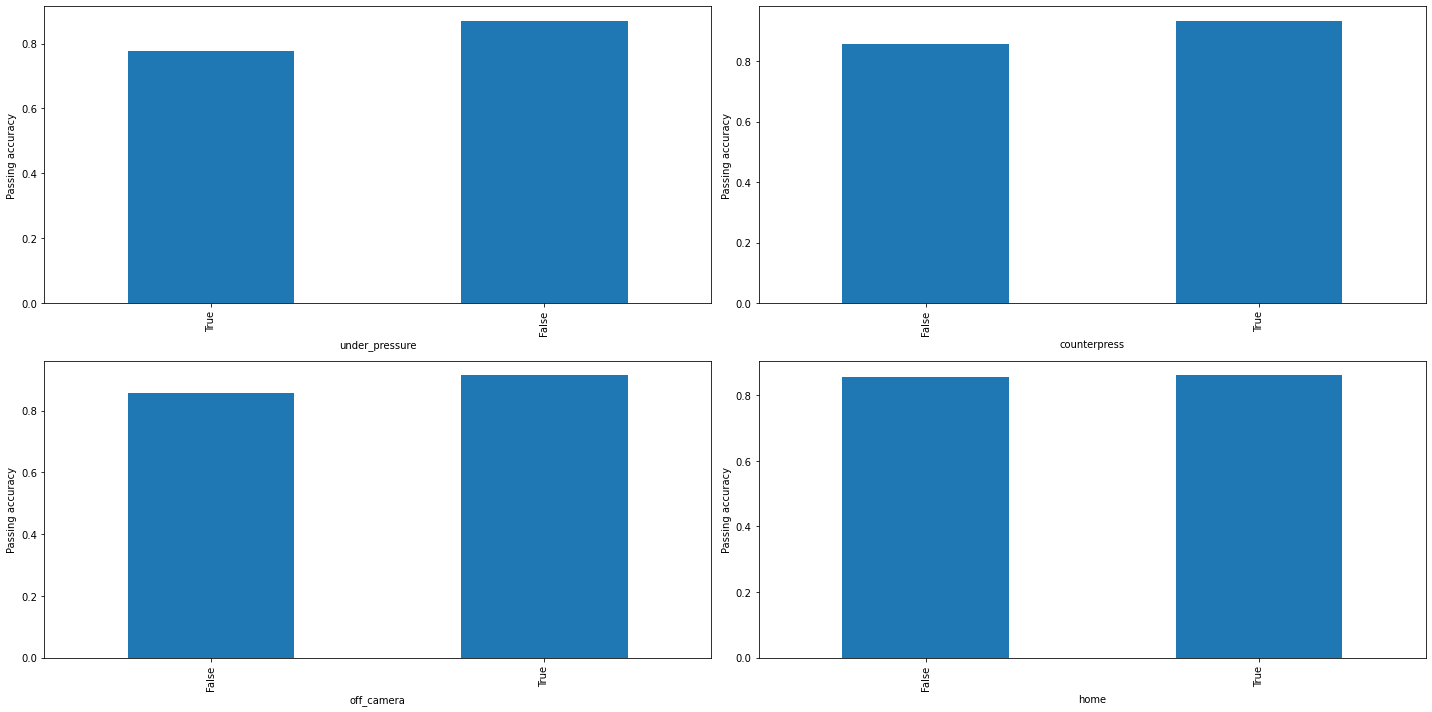

In [14]:
fig, axes = plt.subplots(2,2, figsize=(20, 10))

for i, column in enumerate(["under_pressure", "counterpress", "off_camera", "home"], 1):
    ax = plt.subplot(2, 2, i)
    match_passes.groupby(column)["outcome"].value_counts(normalize=True).loc[:,"Completed"].sort_values().plot.bar(ax=ax)
    ax.set_ylabel("Passing accuracy")

fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


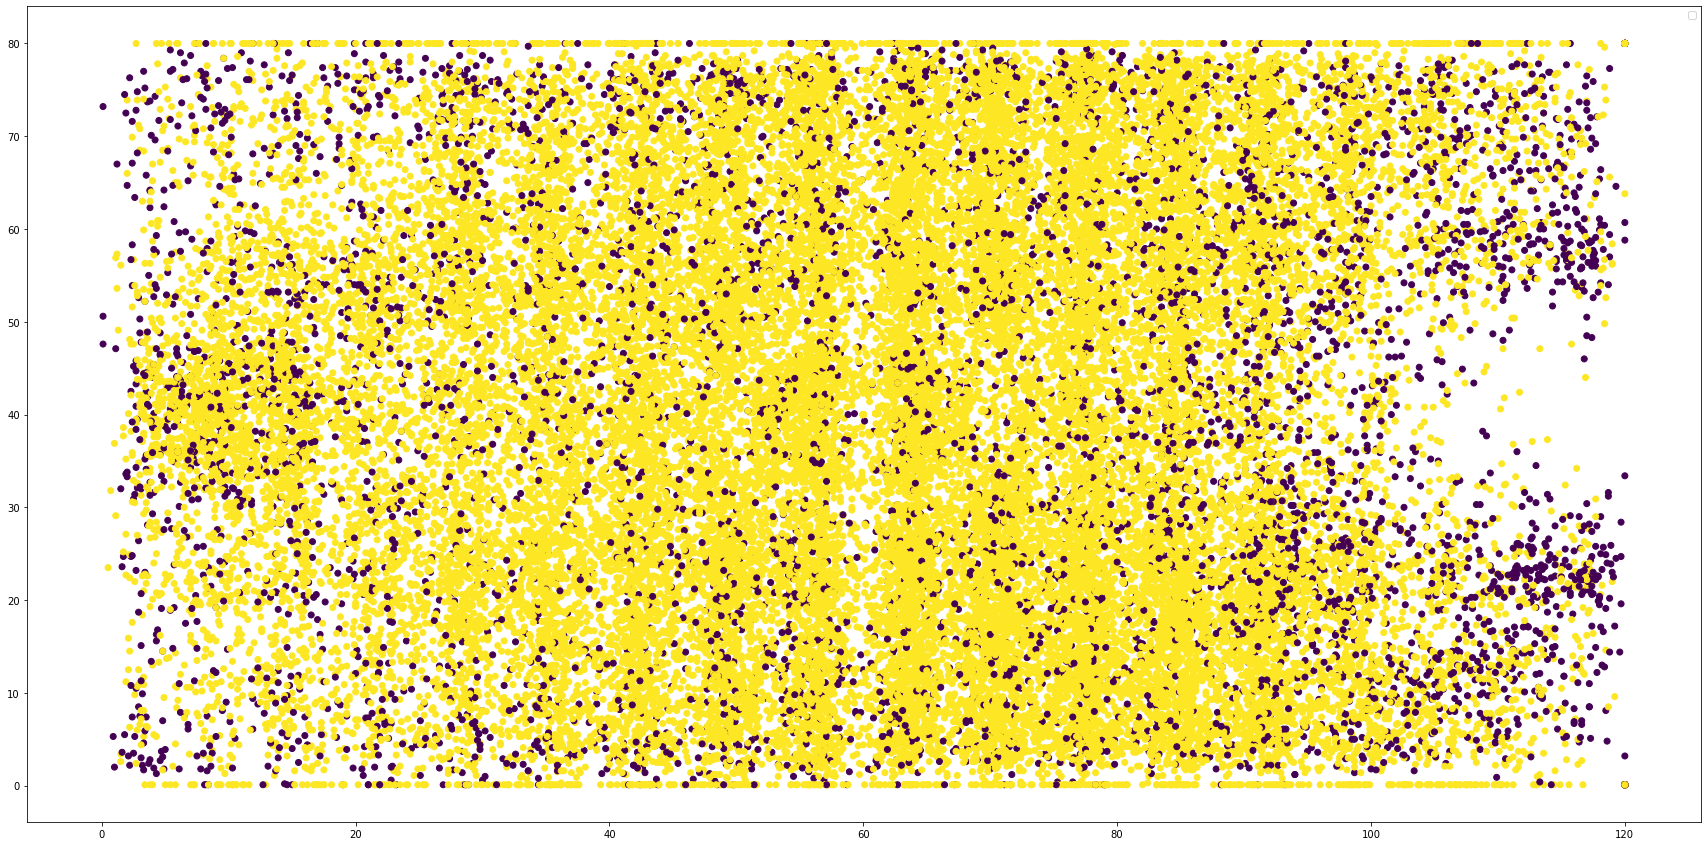

In [15]:
plt.figure(figsize=(30,15))
locations = match_passes["location"].apply(pd.Series)
locations.columns = ["x", "y"]
plt.scatter(locations["x"], locations["y"], c = match_passes["outcome"] == "Completed")
plt.legend();

In [16]:
match_passes.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'type',
       'possession', 'possession_team', 'play_pattern', 'team', 'player',
       'position', 'location', 'duration', 'related_events', 'pass',
       'match_id', 'possession_team_id', 'player_id', 'under_pressure',
       'counterpress', 'off_camera', 'match_week', 'home_team', 'away_team',
       'out', 'outcome', 'recipient_id', 'length', 'angle', 'height',
       'body_part', 'end_location', 'home', 'opponent', 'n_related_events'],
      dtype='object')

## Modeling

In [65]:
TARGET = "outcome"
FEATURES = ["minute", "play_pattern", "location", "counterpress", "under_pressure", "match_week", "length", "angle", "height", "body_part", "end_location"]

In [122]:
X = match_passes[FEATURES].reset_index(drop=True)
y = (match_passes[TARGET] == "Completed").astype(int).reset_index(drop=True)

In [123]:
X["location_x"], X["location_y"] = X["location"].apply(pd.Series).T.values
X["end_location_x"], X["end_location_y"] = X["end_location"].apply(pd.Series).T.values
X = X.drop(["location", "end_location"], axis=1)

X["counterpress"] = X["counterpress"].astype(int)
X["under_pressure"] = X["under_pressure"].astype(int)

In [124]:
CATEGORICAL_COLUMNS = ["play_pattern", "height", "body_part"]
encoder = OneHotEncoder()
encoded_cat = pd.DataFrame(encoder.fit_transform(X[CATEGORICAL_COLUMNS]).toarray(), columns = encoder.get_feature_names(input_features=CATEGORICAL_COLUMNS)).astype(int)

X = pd.concat([X, encoded_cat], axis=1).drop(CATEGORICAL_COLUMNS, axis=1)

/Users/ali/mambaforge/envs/ali/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [150]:
model = xgb.XGBClassifier(n_estimators = 700, early_stopping_rounds=50, learning_rate=0.05, max_depth = 4, eval_metric="auc")
model.fit(X_train, y_train,
         eval_set = [(X_train, y_train), (X_test, y_test)],
         verbose=50
         )

[0]	validation_0-auc:0.83335	validation_1-auc:0.82629
[50]	validation_0-auc:0.89614	validation_1-auc:0.88370
[100]	validation_0-auc:0.91368	validation_1-auc:0.90323
[150]	validation_0-auc:0.91961	validation_1-auc:0.90771
[200]	validation_0-auc:0.92372	validation_1-auc:0.90997
[250]	validation_0-auc:0.92647	validation_1-auc:0.91118
[300]	validation_0-auc:0.92938	validation_1-auc:0.91245
[350]	validation_0-auc:0.93192	validation_1-auc:0.91353
[400]	validation_0-auc:0.93388	validation_1-auc:0.91389
[450]	validation_0-auc:0.93609	validation_1-auc:0.91418
[500]	validation_0-auc:0.93806	validation_1-auc:0.91448
[550]	validation_0-auc:0.94000	validation_1-auc:0.91443
[568]	validation_0-auc:0.94063	validation_1-auc:0.91443


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [151]:
print("AUC score:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]), 3))
confusion_matrix(y_test, model.predict(X_test))

AUC score: 0.915


array([[ 331,  241],
       [ 123, 3339]])

In [152]:
pd.DataFrame(model.feature_importances_, index=model.feature_names_in_, columns =["importance"]).sort_values("importance", ascending= False).T

,height_Ground Pass,height_High Pass,under_pressure,end_location_x,angle,length,body_part_None,pass_distance,end_location_y,play_pattern_From Throw In,body_part_Keeper Arm,play_pattern_Regular Play,body_part_Head,body_part_Left Foot,location_y,location_x,play_pattern_From Kick Off,body_part_Other,height_Low Pass,play_pattern_From Counter,body_part_No Touch,body_part_Right Foot,play_pattern_From Goal Kick,play_pattern_From Corner,counterpress,minute,match_week,play_pattern_From Free Kick,body_part_Drop Kick,play_pattern_Other,play_pattern_From Keeper
importance,0.430975,0.206576,0.038949,0.036154,0.031294,0.03049,0.023882,0.022616,0.02234,0.013623,0.012666,0.012385,0.011862,0.011621,0.008982,0.008339,0.008001,0.007621,0.007438,0.00702,0.006928,0.006235,0.006224,0.006187,0.005425,0.004443,0.004028,0.003866,0.003828,0.0,0.0
